<a href="https://colab.research.google.com/github/arminsoltan/mohaymen/blob/main/Phase02/Intel_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
import torch
from torchvision import datasets, models, transforms
import torch.optim as optim
import pandas as pd
import warnings
import os
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Resize, Normalize, RandomHorizontalFlip 
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
from tqdm import tqdm
import copy
seed = torch.manual_seed(0)

In [2]:
warnings.filterwarnings("ignore")

In [3]:
!unzip "/content/drive/MyDrive/dataset/Intel.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Intel/seg_train/forest/14669.jpg  
  inflating: /content/Intel/seg_train/forest/14700.jpg  
  inflating: /content/Intel/seg_train/forest/14712.jpg  
  inflating: /content/Intel/seg_train/forest/14727.jpg  
  inflating: /content/Intel/seg_train/forest/14733.jpg  
  inflating: /content/Intel/seg_train/forest/1475.jpg  
  inflating: /content/Intel/seg_train/forest/14767.jpg  
  inflating: /content/Intel/seg_train/forest/14780.jpg  
  inflating: /content/Intel/seg_train/forest/14785.jpg  
  inflating: /content/Intel/seg_train/forest/14786.jpg  
  inflating: /content/Intel/seg_train/forest/14795.jpg  
  inflating: /content/Intel/seg_train/forest/14809.jpg  
  inflating: /content/Intel/seg_train/forest/14853.jpg  
  inflating: /content/Intel/seg_train/forest/14900.jpg  
  inflating: /content/Intel/seg_train/forest/14931.jpg  
  inflating: /content/Intel/seg_train/forest/14956.jpg  
  inflating: /content/Intel/seg_train/

In [4]:
# transform = transforms.Compose[transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
train_dir = '/content/Intel/seg_train'
test_dir = '/content/Intel/seg_test'
outcomes = os.listdir(train_dir)
print(outcomes)

['buildings', 'forest', 'sea', 'mountain', 'glacier', 'street']


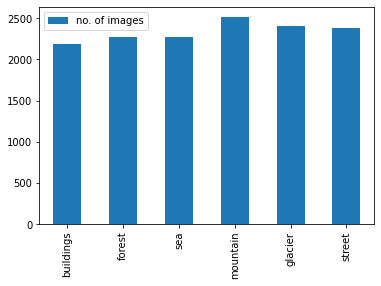

In [5]:
nums = {}
for outcome in outcomes:
  nums[outcome] = len(os.listdir(train_dir + '/' + outcome))
image_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
image_per_class.plot.bar()

In [6]:
image_per_class

,no. of images
buildings,2191
forest,2271
sea,2274
mountain,2512
glacier,2404
street,2382


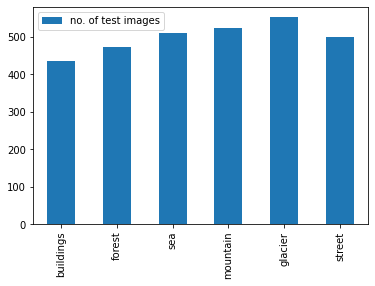

In [7]:
nums_test = {}
outcomes_test = os.listdir(test_dir)
for outcome in outcomes_test:
  nums_test[outcome] = len(os.listdir(test_dir + '/' + outcome))
test_image_per_class = pd.DataFrame(nums_test.values(), index=nums_test.keys(), columns=["no. of test images"])
test_image_per_class.plot.bar()

In [8]:
test_image_per_class

,no. of test images
buildings,437
forest,474
sea,510
mountain,525
glacier,553
street,501


In [9]:
transform_train = transforms.Compose([Resize((224, 224)),
                                      ToTensor(),
                                      Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_test = transforms.Compose([Resize((224, 224)),
                                     ToTensor(),
                                     Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [10]:
train_data = ImageFolder(root=train_dir, transform=transform_train)
test_data = ImageFolder(root=test_dir, transform=transform_test)

In [11]:
batch_size = 64
valid_size = 0.2
learning_rate = 0.1

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [12]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def train_model(model, criterion, optimizer, schedular, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  pbar = tqdm(range(num_epochs))
  for epoch in pbar:
      
      model.train()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for images, labels in (train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(True):
          outputs = model(images)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

      schedular.step()
      
      # model.eval()
      # for images, labels in (test_dataloader):
      #   images = images.to(device)
      #   labels = labels.to(device)
        
      #   loss = criterion()


      epoch_loss = running_loss / len(train_dataloader)
      epoch_acc = running_corrects.double() / len(train_dataloader)

      pbar.set_postfix({'loss': epoch_loss, "accuracy": epoch_acc})
      
      if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      
  time_elapsed = time.time() - since
  
  print("Best val Acc: {:4f}".format(best_acc))

  model.load_state_dict(best_model_wts)
  return model


In [22]:
# Load a pretrained model and reset final fully connected layer

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 6)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)




  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:59<?, ?it/s, loss=71.3, accuracy=tensor(42.7614, device='cuda:0', dtype=torch.float64)]

 20%|██        | 1/5 [00:59<03:58, 59.67s/it, loss=71.3, accuracy=tensor(42.7614, device='cuda:0', dtype=torch.float64)]

 20%|██        | 1/5 [01:59<03:58, 59.67s/it, loss=34.3, accuracy=tensor(55.8977, device='cuda:0', dtype=torch.float64)]

 40%|████      | 2/5 [01:59<02:58, 59.59s/it, loss=34.3, accuracy=tensor(55.8977, device='cuda:0', dtype=torch.float64)]

 40%|████      | 2/5 [02:58<02:58, 59.59s/it, loss=25.1, accuracy=tensor(56.9602, device='cuda:0', dtype=torch.float64)]

 60%|██████    | 3/5 [02:58<01:58, 59.40s/it, loss=25.1, accuracy=tensor(56.9602, device='cuda:0', dtype=torch.float64)]

 60%|██████    | 3/5 [03:57<01:58, 59.40s/it, loss=20.8, accuracy=tensor(57.9318, device='cuda:0', dtype=torch.float64)]

 80%|████████  | 4/5 [03:57<00:59, 59.38s/it, loss=20.8, accuracy=tensor(57.9318, device='cuda:0', dtype=torch.fl

Best val Acc: 58.090909


In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:40<02:40, 40.20s/it]



 40%|████      | 2/5 [01:19<01:59, 39.80s/it]



 60%|██████    | 3/5 [01:58<01:19, 39.71s/it]



 80%|████████  | 4/5 [02:37<00:39, 39.62s/it]



100%|██████████| 5/5 [03:17<00:00, 39.43s/it]


Best val Acc: 57.562500
